# Sheerwater Walkthrough

This example walks through accessing data in sheerwater, computing a metric manually, then comparing that metric to one we've already comptued in Sheerwater. We also walk through strategies for faster data access and talk about the sheerwater data storage system - Nuthatch

## Data storage system and philosophy

Because sheerwater and transforms terra- and sometimes peta-byte scale datasets, we built a tool, [Nuthatch](github.com/rhiza-research/nuthatch),
to store, recall, and slice these datasets and enable more efficient access and computation.  In Nuthatch, the results of functions
are stored in data-type specific caches based on the function name and the arguments that are passed. When the same function is called with
the same key arguments, the data is returned rather than running the function. Datasets are stored in "global" caches in the cloud,
and can also be sliced down in time and space to be saved to your machine for faster access.
 
When you install Sheerwater, your environment is automatically configured to access all of Sheerwater's public data through Nuthatch.
Therefore when you call Sheerwater functions, you will mostly just be hitting pre-computed results, but the code serves as a self-documenting
API of how the data was transformed from its source to the result and enables users with enough compute to rerun the code either for
purposes of verification or to compute the functions with arguments that have not already been computed and stored.

## First data access

In this example we access the IMERG dataset, aggregated on a 7 day rolling window on a global 0.25x0.25 grid in Africa.

Datasets are available at many grids and aggregations as specified in the README of this repo.

In [11]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sheerwater.data import chirps, imerg
from sheerwater.forecasts import graphcast, ecmwf_ifs_er_debiased
from sheerwater.metrics import metric
from sheerwater.utils import apply_mask

In [12]:
start_time = "2019-01-01"
end_time = "2019-12-31"

### Datset slicing and local storage

While the IMERG dataset is available from 1998 to present, we use the start_time, and end_time arguments to access a smaller slice. We also set `region="africa"` to select only the data in Africa.

After fetching this subset of the IMERG data, setting `cache_mode='local'` instructs Nuthatch to save this data locally. The first time you call this, you may need to read a few hundred MB of data from the cloud, but repeated calls to this same function will hit your local storage instead.

All data in sheerwater is stored in Xarray with time, lat, and lon dimensions on a set of standard grids.

nuthatch WARNING: Writing to default local cache location ~/.nuthatch/caches
nuthatch INFO: Processing data by running function imerg... 
nuthatch INFO: Data processing can be computationally intensive. Ensure you have sufficient compute resources.
nuthatch INFO: Found cache for imerg_rolled/agg_days_7/grid_global0_25/version_final with backend zarr in root cache
nuthatch INFO: Found cache for get_country_gdf/ with backend basic in root cache
nuthatch INFO: Memoizing get_country_gdf/ in your local memory for fast recall.
nuthatch INFO: Caching result for get_country_gdf/ in basic with namespace default in local cache.
nuthatch INFO: Found cache for get_country_gdf/ in memory.
nuthatch INFO: Found cache for spatial_mask/grid_global0_25/mask_lsm with backend zarr in root cache
nuthatch INFO: Memoizing spatial_mask/grid_global0_25/mask_lsm/region_global in your local memory for fast recall.
nuthatch INFO: Caching result for spatial_mask/grid_global0_25/mask_lsm/region_global in zarr with 

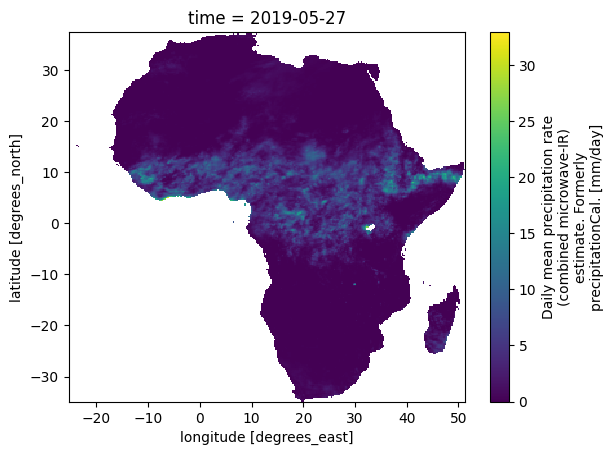

In [13]:
%%time
ds = imerg(start_time, end_time, agg_days=7, grid='global0_25', mask="lsm", region="africa", cache_mode='local')
ds.precip.sel(time="2019-05-27").plot(x='lon')

### Accessing the data on a 1.5x1.5 Grid

We access the data on a 1.5x1.5 grid that aligns with the ECMWF IFS ER grid so that we can compare the two.

nuthatch WARNING: Writing to default local cache location ~/.nuthatch/caches
nuthatch INFO: Found cache for imerg/agg_days_7/end_time_2019-12-31/grid_global1_5/mask_lsm/region_africa/start_time_2019-01-01/variable_precip with backend zarr in local cache
CPU times: user 59 ms, sys: 24.2 ms, total: 83.2 ms
Wall time: 84.5 ms


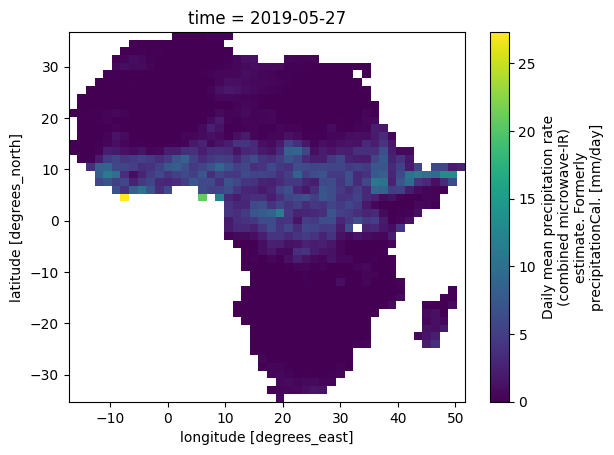

In [15]:
%%time
ds_truth = imerg(start_time, end_time, agg_days=7, grid='global1_5', mask="lsm", region="africa", cache_mode='local')
ds_truth.precip.sel(time="2019-05-27").plot(x='lon')

### Accessing ECMWF IFS ER Debiased

Sheerwater has already has the debiased versions of ECMWF IFS ER. We get it on the same grid, region, and time as IMERG data above and
save it locally as well for fast repeated access.

In [16]:
%%time
ds_fcst = ecmwf_ifs_er_debiased(start_time, end_time, grid='global1_5', agg_days=7, mask="lsm", region="africa", cache_mode='local')
ds_fcst

nuthatch WARNING: Writing to default local cache location ~/.nuthatch/caches
nuthatch INFO: Processing data by running function ecmwf_ifs_er_debiased... 
nuthatch INFO: Data processing can be computationally intensive. Ensure you have sufficient compute resources.
nuthatch INFO: Caching disabled for arg values {'agg_days': [1, 7, 14]}
nuthatch INFO: Processing data by running function ifs_extended_range_rolled... 
nuthatch INFO: Data processing can be computationally intensive. Ensure you have sufficient compute resources.
nuthatch INFO: Caching disabled for arg values {'grid': 'global1_5'}
nuthatch INFO: Processing data by running function ifs_extended_range_debiased_regrid... 
nuthatch INFO: Data processing can be computationally intensive. Ensure you have sufficient compute resources.
nuthatch INFO: Found cache for ifs_extended_range_debiased/grid_global1_5/margin_in_days_6/run_type_average/time_group_weekly/variable_precip with backend zarr in root cache
nuthatch INFO: Found cache 

[('start_date', np.float64(130.0)), ('lead_time', np.float64(1.0)), ('lat', np.float64(48.0)), ('lon', np.float64(46.0))]


nuthatch INFO: Caching result for ifs_extended_range_debiased_regrid/end_time_2020-02-15/grid_global1_5/margin_in_days_6/mask_lsm/region_africa/run_type_average/start_time_2018-11-16/time_group_weekly/variable_precip in zarr with namespace default in local cache.


[('start_date', np.float64(130.0)), ('lead_time', np.float64(1.0)), ('lat', np.float64(48.0)), ('lon', np.float64(46.0))]


nuthatch INFO: Caching result for ifs_extended_range_rolled/agg_days_7/debiased_True/end_time_2020-02-15/grid_global1_5/mask_lsm/prob_type_deterministic/region_africa/start_time_2018-11-16/variable_precip in zarr with namespace default in local cache.


[('start_date', np.float64(130.0)), ('lead_time', np.float64(1.0)), ('lat', np.float64(48.0)), ('lon', np.float64(46.0))]


nuthatch INFO: Caching result for ecmwf_ifs_er_debiased/agg_days_7/end_time_2019-12-31/grid_global1_5/mask_lsm/prob_type_deterministic/region_africa/start_time_2019-01-01/variable_precip in zarr with namespace default in local cache.
CPU times: user 3.62 s, sys: 2.02 s, total: 5.64 s
Wall time: 37.1 s


<xarray.Dataset> Size: 7MB
Dimensions:               (time: 140, prediction_timedelta: 6, lat: 48, lon: 46)
Coordinates:
  * time                  (time) datetime64[ns] 1kB 2018-11-19 ... 2020-03-19
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 48B 0 days ....
  * lat                   (lat) float32 192B -34.5 -33.0 -31.5 ... 34.5 36.0
  * lon                   (lon) float32 184B -16.5 -15.0 -13.5 ... 49.5 51.0
Data variables:
    precip                (lat, lon, time, prediction_timedelta) float32 7MB dask.array<chunksize=(48, 46, 18, 6), meta=np.ndarray>
Attributes:
    start_time:  2018-11-16
    end_time:    2020-02-15
    grid:        global1_5
    mask:        lsm
    region:      africa
    prob_type:   deterministic
    agg_days:    7.0
    variable:    precip
    units:       mm / day

### Forecast data format

All forecast data in sheerwater is stored in Xarray with time, lat, lon, and prediction_timedelta dimensions.

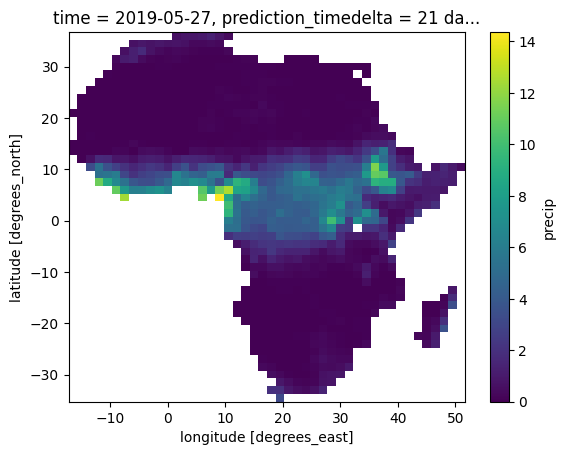

In [17]:
lead = np.timedelta64(21, 'D')
ds_fcst.precip.sel(time="2019-05-27", prediction_timedelta=lead).plot(x='lon')

#### We can plot the errors between the IMERG and ECWMF IFS ER at a specific date

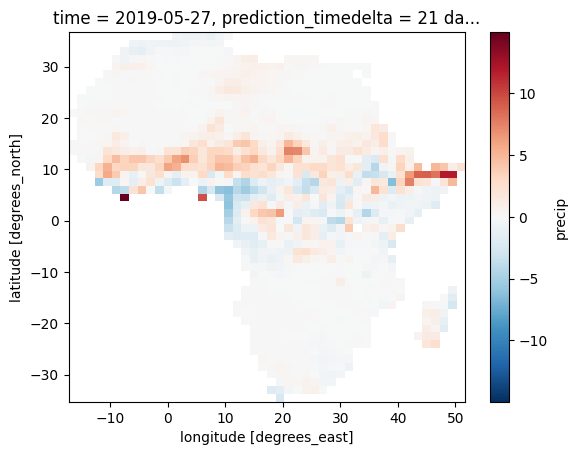

In [18]:
error = ds_truth - ds_fcst
error.isel(prediction_timedelta=3).sel(time="2019-05-27").precip.plot(x='lon')

#### And also compute the _unweighted_ MAE between the two for the year for each of the 6 weeks in the ECMWF IFS ER Forecast

In [19]:
mae_computed = np.abs(error).mean(dim=['lat', 'lon', 'time'])
print("Unweighted error of", mae_computed.precip.values, "mm / day of rainfall")

Unweighted error of [0.9132905 0.9863897 1.0369282 1.0531436 1.0601251 1.0663867] mm / day of rainfall


#### All sheerwater metrics are latitude weighted. The following code computes the latitude weighted MAE between IMERG and ECMWF IFS ER

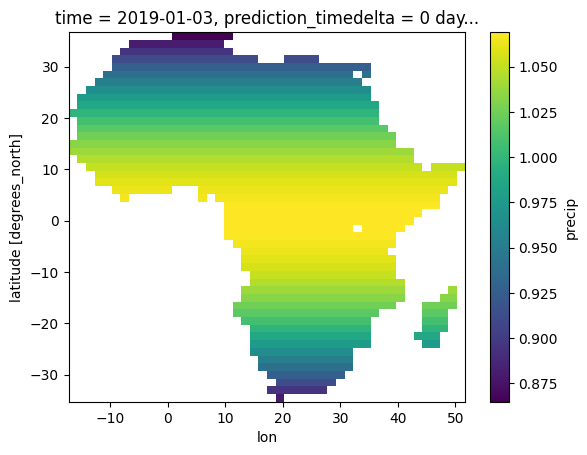

In [20]:
from sheerwater.utils import latitude_weights
weights = latitude_weights(error)
weights = weights.where(error.notnull(), np.nan, drop=False)
weights.precip.isel(time=0, prediction_timedelta=0).plot(x='lon')

In [21]:
mae_weighted = (((np.abs(error) * weights).sum(dim=['lat', 'lon'])) / weights.sum(dim=['lat', 'lon'])).mean(dim='time')
print("Weighted error of", mae_weighted.precip.values, "mm / day of rainfall")

Unweighted error of [0.93734264 1.0099219  1.0608622  1.0774331  1.0843533  1.0908204 ] mm / day of rainfall


### Computing a metric with the sheerwater metrics library

We can now compare our metric code the that computed by the sheerwater metrics library. The metrics library takes all the same arguments as the forecasts and data, but you pass in the forecast and truth source to compare as strings.

Forecasts and other data sources are registered by name in the sheerwater library. You can see what is registered like so:

In [25]:
from sheerwater.interfaces import list_forecasts, list_data
print(list_forecasts())
print(list_data())

['ecmwf_ifs_er', 'ecmwf_ifs_er_debiased', 'fuxi', 'gencast', 'graphcast', 'salient', 'salient_gem', 'climatology_2015', 'climatology_2020', 'climatology_trend_2015', 'climatology_rolling']
['chirp_v2', 'chirp_v3', 'chirps_v2', 'chirps_v3', 'chirps', 'ghcn', 'ghcn_avg', 'imerg_final', 'imerg_late', 'imerg', 'tahmo', 'tahmo_avg', 'cbam', 'era5_land', 'era5']


### Now we can compute the same metric as above and verify that the weighted MAE for this time and space region match

In [27]:
mae_sheerwater = metric(start_time, end_time, "precip", agg_days=7, 
                        forecast="ecmwf_ifs_er_debiased",
                        truth="imerg",
                        metric_name="mae",
                        grid="global1_5",
                        mask="lsm",
                        region="africa",
                        cache_mode='local')

nuthatch WARNING: Writing to default local cache location ~/.nuthatch/caches
nuthatch INFO: Found cache for metric/agg_days_7/end_time_2019-12-31/forecast_ecmwf_ifs_er_debiased/grid_global1_5/mask_lsm/metric_name_mae/region_africa/space_grouping_None/spatial_False/start_time_2019-01-01/time_grouping_None/truth_imerg/variable_precip with backend zarr in root cache
nuthatch INFO: Caching result for metric/agg_days_7/end_time_2019-12-31/forecast_ecmwf_ifs_er_debiased/grid_global1_5/mask_lsm/metric_name_mae/region_africa/space_grouping_None/spatial_False/start_time_2019-01-01/time_grouping_None/truth_imerg/variable_precip in zarr with namespace default in local cache.


In [28]:
mae_sheerwater.mae.values

array([0.93734235, 1.0099201 , 1.0608618 , 1.0774329 , 1.0843537 ,
       1.0908198 ], dtype=float32)

#### This is slightly different than the unweighted MAE we first computed

In [30]:
print("Unweighted error of", mae_computed.precip.values, "mm / day of rainfall")

Unweighted error of [0.9132905 0.9863897 1.0369282 1.0531436 1.0601251 1.0663867] mm / day of rainfall


## Registering your own forecast for evaluation

You can register your own forecast to be evaluated with the evaluation library as well. Forecasts are expected to adhere to the interface below.

In [38]:
from sheerwater.interfaces import forecast
import xarray as xr

@forecast()
def my_new_forecast(start_time=None, end_time=None, variable="precip", agg_days=1, prob_type='deterministic',
                    grid='global1_5', mask='lsm', region="africa"):
    return xr.ones_like(ds_fcst)

In [39]:
new_mae = metric(start_time, end_time, "precip", agg_days=7, 
                        forecast="my_new_forecast",
                        truth="imerg",
                        metric_name="mae",
                        grid="global1_5",
                        mask="lsm",
                        region="africa",
                        cache_mode='local')

nuthatch WARNING: Writing to default local cache location ~/.nuthatch/caches
nuthatch INFO: Cache doesn't exist for metric/agg_days_7/end_time_2019-12-31/forecast_my_new_forecast/grid_global1_5/mask_lsm/metric_name_mae/region_africa/space_grouping_None/spatial_False/start_time_2019-01-01/time_grouping_None/truth_imerg/variable_precip in namespace default. Running function.
nuthatch INFO: Processing data by running function metric... 
nuthatch INFO: Data processing can be computationally intensive. Ensure you have sufficient compute resources.
nuthatch INFO: Found cache for imerg/agg_days_7/end_time_2019-12-31/grid_global1_5/mask_lsm/region_africa/start_time_2019-01-01/variable_precip with backend zarr in local cache
nuthatch INFO: Memoizing imerg/agg_days_7/end_time_2019-12-31/grid_global1_5/mask_lsm/region_africa/start_time_2019-01-01/variable_precip in your local memory for fast recall.
nuthatch INFO: Processing data by running function global_statistic... 
nuthatch INFO: Data proces

[('lat', np.float64(48.0)), ('lon', np.float64(46.0)), ('time', np.float64(30.0)), ('prediction_timedelta', np.float64(6.0))]


nuthatch INFO: Found cache for get_country_gdf/ in memory.
nuthatch INFO: Found cache for region_labels/grid_global1_5/region_africa/space_grouping_global with backend zarr in root cache
nuthatch INFO: Memoizing region_labels/grid_global1_5/region_africa/space_grouping_global in your local memory for fast recall.
nuthatch INFO: Caching result for region_labels/grid_global1_5/region_africa/space_grouping_global in zarr with namespace default in local cache.
nuthatch INFO: Found cache for spatial_mask/grid_global1_5/mask_lsm/region_global in memory.
nuthatch INFO: Found cache for get_country_gdf/ in memory.
nuthatch INFO: Found cache for get_country_gdf/ in memory.
nuthatch INFO: Caching result for metric/agg_days_7/end_time_2019-12-31/forecast_my_new_forecast/grid_global1_5/mask_lsm/metric_name_mae/region_africa/space_grouping_None/spatial_False/start_time_2019-01-01/time_grouping_None/truth_imerg/variable_precip in zarr with namespace default in local cache.


In [41]:
new_mae.mae.values

array([2.111838, 2.111838, 2.111838, 2.111838, 2.111838, 2.111838],
      dtype=float32)